In [68]:
import pandas as pd
import datetime
import numpy as np


from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import seaborn as sns

import warnings                               
warnings.filterwarnings('ignore')

Thaughts:
 - Holidays dont make sense to add
 - Seasonality is hard in general with this data
 - Including work with exogenous variables since that is where i spent most of my time before realizing we cannot use them unless we predict them aswell

In [40]:
df = pd.read_csv('../train.csv')
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
df = df.groupby(df['Datetime']).mean()
df[-10:]

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-06,345.379836,NaN,NaN,2.302958,2.866026,2.866026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.009986,69.359451,NaN,2.000000,164.009986,5.009965
2020-03-07,516.674962,25.423446,45.528870,0.497295,1.025067,1.025067,66.457802,57.630624,1300.620234,76.321828,75.603281,37.179137,37.575735,165.742392,90.663521,11.661680,2.656489,165.742392,5.516212
2020-03-08,629.447133,28.916827,44.785470,1.546212,2.000779,2.000779,64.806025,56.711548,1229.101450,71.544553,70.871235,38.171376,40.593015,176.555238,108.485335,11.024436,2.032520,176.555238,5.841943
2020-03-09,673.519002,28.132108,44.892881,1.261475,1.686503,1.686503,64.903175,56.511082,1251.636031,72.267975,71.592853,38.148456,39.922307,173.082233,103.229681,11.220090,2.025862,173.082233,5.990401
2020-03-10,581.532630,28.449302,44.363123,1.052545,1.533936,1.533936,63.891030,55.689005,1208.605722,69.229363,68.523818,38.142220,40.013794,171.986034,100.525473,10.865780,2.552846,171.986034,5.709830
2020-03-11,466.289248,28.276232,44.059155,0.482881,0.934002,0.934002,64.106761,56.921031,1163.017505,67.939614,67.174603,38.635532,39.955577,183.729298,71.852813,10.420975,2.030612,183.729298,5.385570
2020-03-12,570.315539,29.094133,44.476550,1.206977,1.629283,1.629283,64.051326,56.194520,1217.638162,70.008635,69.288543,39.978688,40.757739,180.773250,84.040654,10.931663,2.033333,180.773250,5.693483
2020-03-13,619.637333,30.088163,45.903233,2.168904,2.609776,2.609776,65.348205,57.663415,1213.959374,72.745844,72.096953,39.562485,41.600482,187.621975,99.693231,10.884414,2.059259,187.621975,5.765318
2020-03-14,800.312824,29.395626,45.924987,3.361067,3.771943,3.771943,65.975734,57.703463,1283.600520,79.347426,78.702074,39.610160,41.525481,177.635623,141.418250,11.506644,2.032787,177.635623,6.217917


In [41]:
df.shape, df.isna().sum()

((734, 19),
 ActivePower                       0
 AmbientTemperatue                 4
 BearingShaftTemperature         273
 Blade1PitchAngle                428
 Blade2PitchAngle                428
 Blade3PitchAngle                428
 GearboxBearingTemperature       273
 GearboxOilTemperature           273
 GeneratorRPM                    273
 GeneratorWinding1Temperature    273
 GeneratorWinding2Temperature    273
 HubTemperature                  273
 MainBoxTemperature              273
 NacellePosition                   3
 ReactivePower                     0
 RotorRPM                        273
 TurbineStatus                   269
 WindDirection                     3
 WindSpeed                         1
 dtype: int64)

Lots of nas lets mean impute.

In [42]:
column_means = df.mean()
df = df.fillna(column_means)
df.isna().sum()

ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

Find variables with strong correlation to engineer some extranuous features for the model.

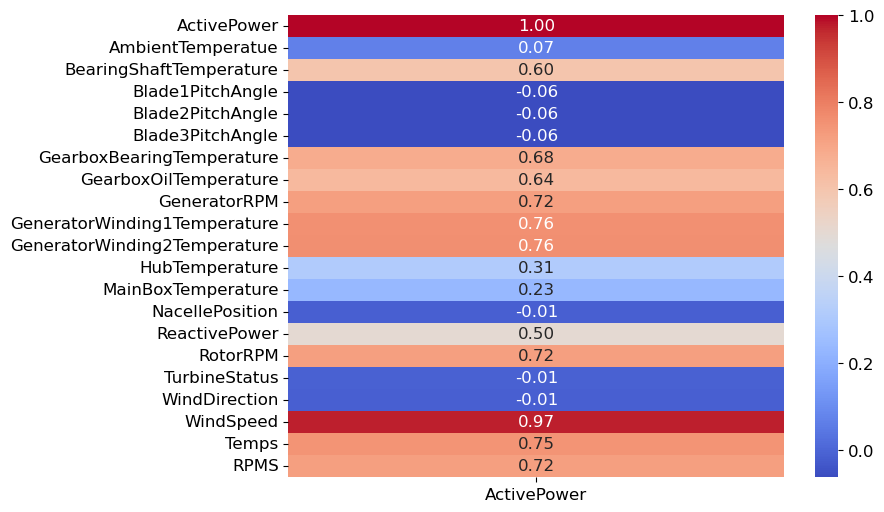

In [43]:
df['Temps'] = (df['GeneratorWinding2Temperature'] + df['GeneratorWinding2Temperature'] + df['GearboxBearingTemperature'] + df['GearboxOilTemperature'])
df['RPMS'] = (df['GeneratorRPM'] + df['RotorRPM'])
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

THis feature looks great, strong linear correlation.

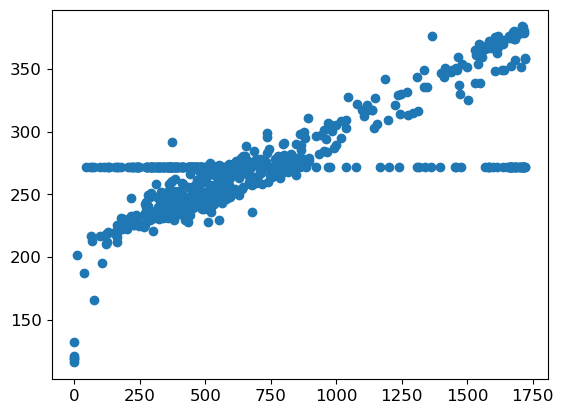

In [44]:
plt.scatter(df['ActivePower'], df['Temps']) #  horizontal line shows the mean impupted values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


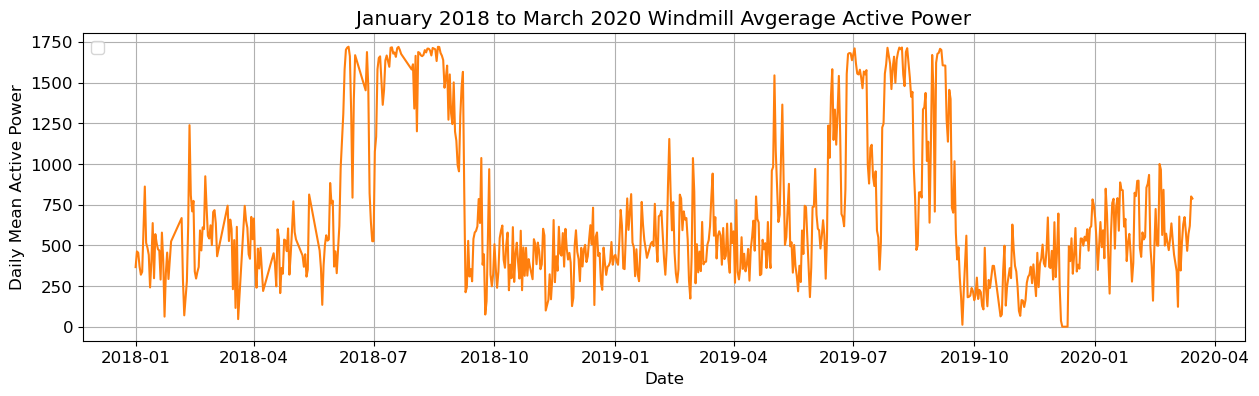

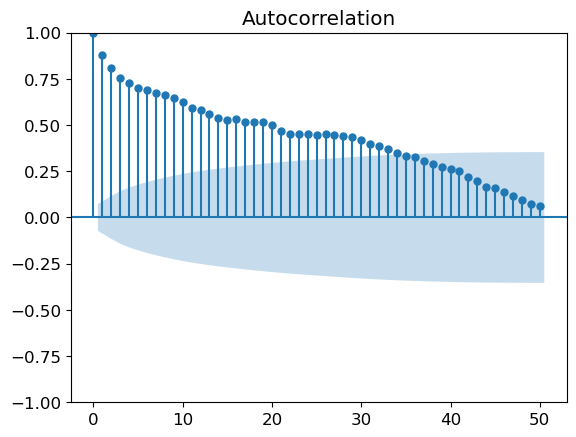

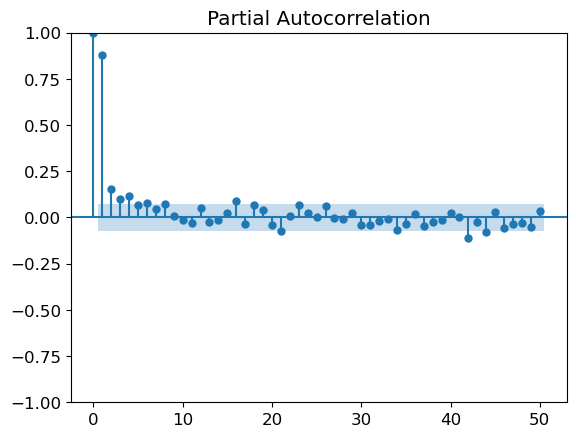


adf test p-value: 0.01792376595212781 ==> stationary


In [45]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Avgerage Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

## SARIMAX model Attempt

In [46]:
def evaluate_models_cv_exog(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m, k):
    K=k
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=31
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(K):

                                train, test = dataset[0:train_size+k*validation_size], dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions=model_fit.predict(start=train_size+k*validation_size, end=train_size+(k+1)*validation_size-1)
                                rmse += np.sqrt(mean_squared_error(np.array(predictions), test))
                            rmse_avg=rmse/K
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

    return (best_rmse), (best_cfg)

SARIMAX Takes way to long to grid search... Lets try other models.

In [47]:
p = [4]
d = [0]
q = [3]
P = [6]
D = [0]
Q = [5]
m = 12
k = 2

#best = evaluate_models_cv_exog(df['ActivePower'], df[['GeneratorRPM', 'WindSpeed', 'Temps']], p, d, q, P, D, Q, m, k) # (0*3)(5,0,3,12) # 711.55

SARIMAX Results Forecasting 30 Days @ (0,0,0), (5,0,3):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'], RMSE: 71.654
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: 69.47
- ['WindSpeed', 'RotorRPM'], RMSE: 

SARIMAX Results Forecasting 30 Days @ (4,0,3), (5,0,3):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'],
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'RotorrRPM'], RMSE: 92.96
- ['WindSpeed', 'RotorRPM'], RMSE: 

SARIMAX Results Forecasting 30 Days @ (6,0,3), (6,0,3,12):
- ['Temps'], RMSE: 
- ['GeneratorRPM', 'WindSpeed'],
- ['Temps', 'RotorRPM'], RMSE: 
- ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: -
- ['WindSpeed', 'RotorRPM'], RMSE: 
Looks good!

In [65]:
k = 31 #  Forecast length 
exog = ['Temps', 'WindSpeed', 'GeneratorRPM'] # Exogenous Variables to Include

# variables to be used in training
y = df['ActivePower'][:-k]
X = df[exog][:-k]

testX, testY = df[exog][-k:], df['ActivePower'][-k:]

In [75]:
best_trend = (0,0,1) #  best[0]
best_seasonality = (6,0,3,21) #  best[1]
model = ARIMA(y, order=(0,0,1), seasonal_order=(6,0,3,21))
m_fit = model.fit()
forecast = m_fit.forecast(k)
print(f'SARIMA({best_trend}), ({best_seasonality}) RMSE: {np.sqrt(np.sum((np.array(forecast) - testY)**2) / testY.shape[0])}')

SARIMA((0, 0, 1)), ((6, 0, 3, 21)) RMSE: 290.7818112299762


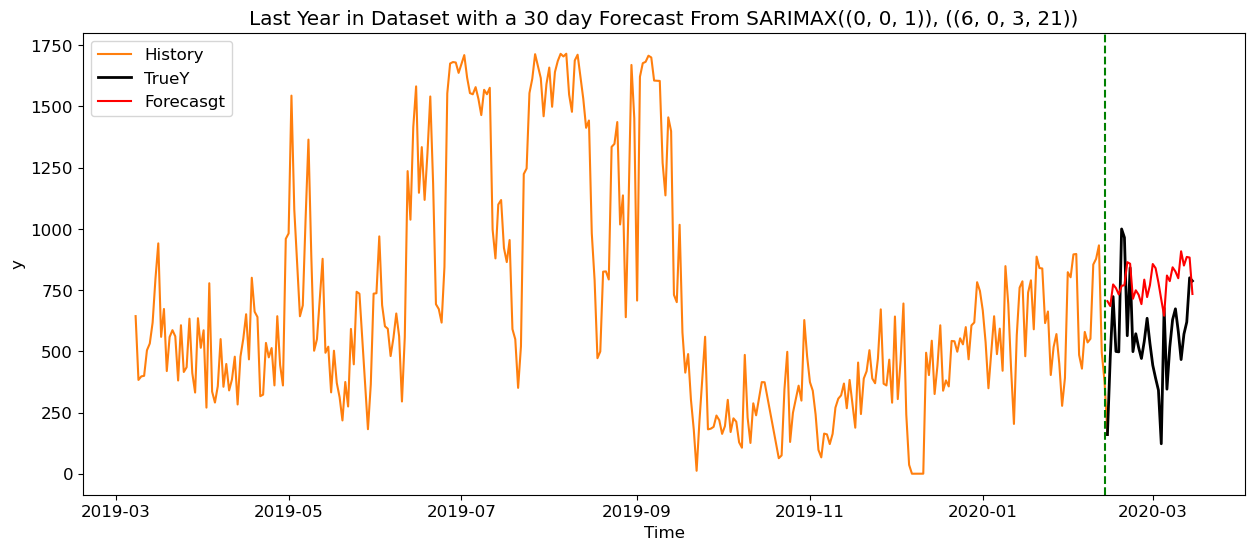

In [76]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY', linewidth=2)
ax.plot(df.index[-k:], forecast, color='red', label='Forecasgt')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title(f'Last Year in Dataset with a 30 day Forecast From SARIMAX({best_trend}), ({best_seasonality})')
plt.legend()

## Theta Model Attempt

In [77]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.forecasting.theta import ThetaModel

theta_model = ThetaModel(y, period=k)
theta_fit = theta_model.fit()

forecasts = theta_fit.forecast(steps=k)
print(f'Theta RMSE: {np.sqrt(np.sum((np.array(forecasts) - testY)**2) / testY.shape[0])}')

Theta RMSE: 240.1059493786587


Not Great.

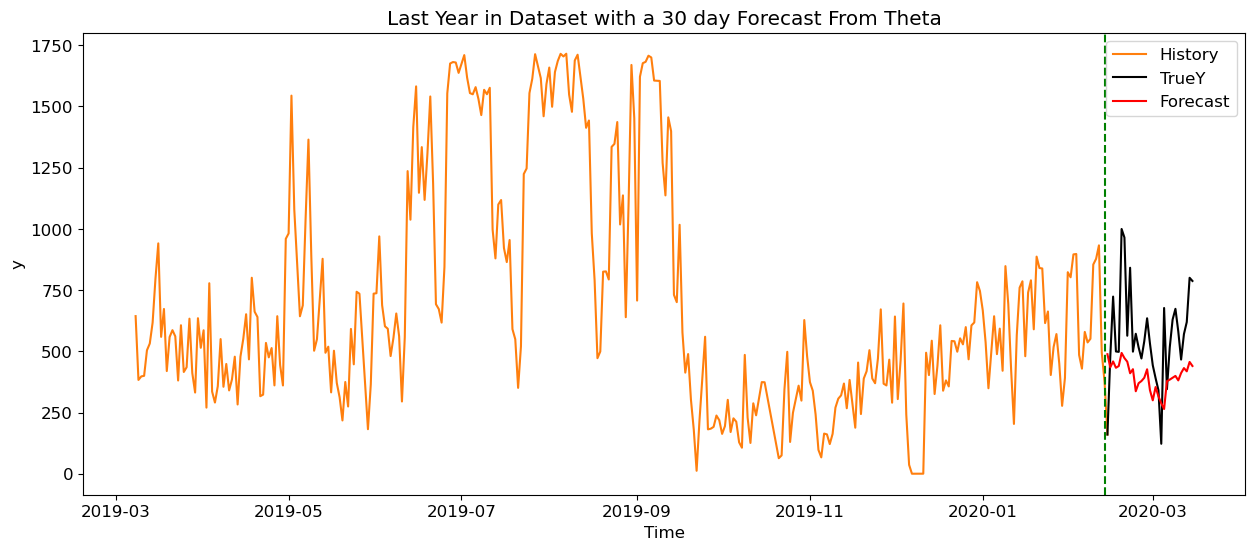

In [78]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
#ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecasts, color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Theta')
plt.legend()

## Prophet Model Attempt

In [79]:
import prophet


# create df 
dataTrain = pd.DataFrame()
dataTrain['y'] = y
dataTrain['ds'] = df.index[:-k]
# for og in exog:
#     dataTrain[og] = X[og]
# make model
m = prophet.Prophet()
m.add_seasonality(name='custom_half', period=21, fourier_order=1) #  custom serasonality
m.changepoint_prior_scale = 0.05
# for og in exog:
#     m.add_regressor(og)
m.fit(dataTrain)
# make df for predictions
future = m.make_future_dataframe(periods=k)
#print(future)
# for og in exog:
#     future[og] = df[og].values
# make predictions
forecast = m.predict(future)
#print(forecast[-10:])
print(f'Prophet RMSE:', np.sqrt(np.sum((np.array(forecast['yhat'][-k:]) - testY)**2) / testY.shape[0]))

22:10:32 - cmdstanpy - INFO - Chain [1] start processing
22:10:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 183.3072511778636


Prophet Results Forecasting 30 Days:
 - ['Temps'], RMSE: 1389.16
 - ['Temps', 'WindSpeed'], RMSE: 133.88
 - ['Temps', 'RotorRPM'], RMSE: 1379.29
 - ['Temps', 'WindSpeed', 'RotorRPM'], RMSE: 103.88
 - ['WindSpeed', 'RotorRPM'], RMSE: 110.19

Looks good!


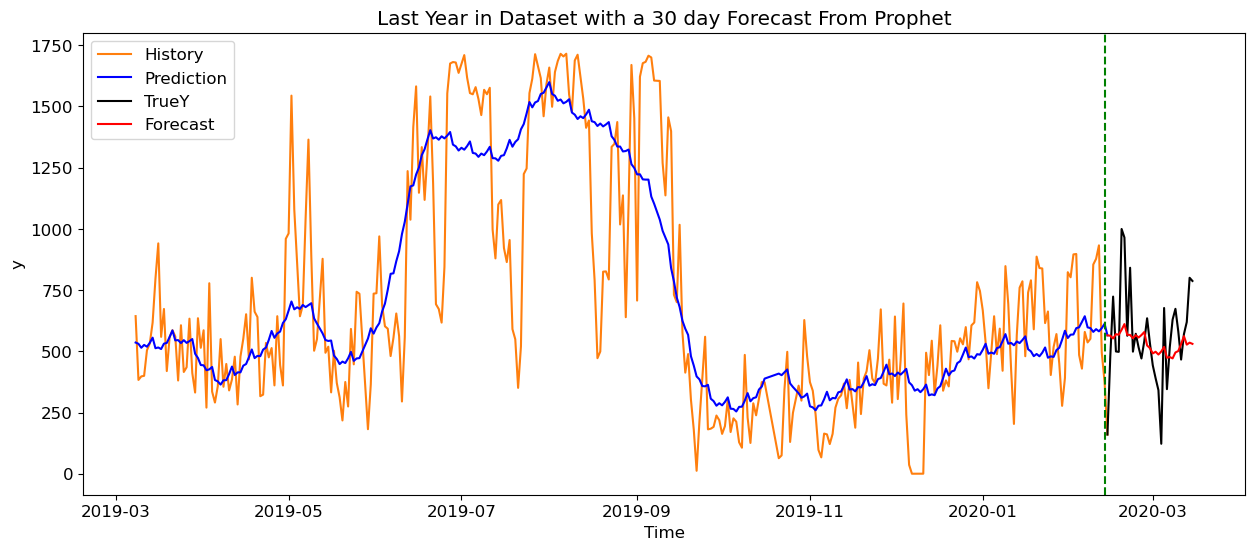

In [80]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast['yhat'][-k:], color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Prophet')
plt.legend()

## Final Model-
Fine tuned Prophet with 

In [81]:
dataTrain = pd.DataFrame()
dataTrain['y'] = df['ActivePower']
dataTrain['ds'] = df.index
m = prophet.Prophet()
m.add_seasonality(name='custom_half', period=21, fourier_order=1) #  custom serasonality
m.changepoint_prior_scale = 0.05
m.fit(dataTrain)
future_oos = m.make_future_dataframe(periods=15)
forecast_oos = m.predict(future_oos)
out = forecast_oos[-15:][['ds', 'yhat']]
out.columns = ['Date', 'Forecasting']
out.to_csv('forecast.csv', index=False)
out

22:10:35 - cmdstanpy - INFO - Chain [1] start processing
22:10:35 - cmdstanpy - INFO - Chain [1] done processing


,Date,Forecasting
734,2020-03-16,569.232029
735,2020-03-17,562.779616
736,2020-03-18,576.737449
737,2020-03-19,596.519502
738,2020-03-20,534.194102
739,2020-03-21,529.861355
740,2020-03-22,504.935810
741,2020-03-23,503.412383
742,2020-03-24,484.301783
743,2020-03-25,489.955528


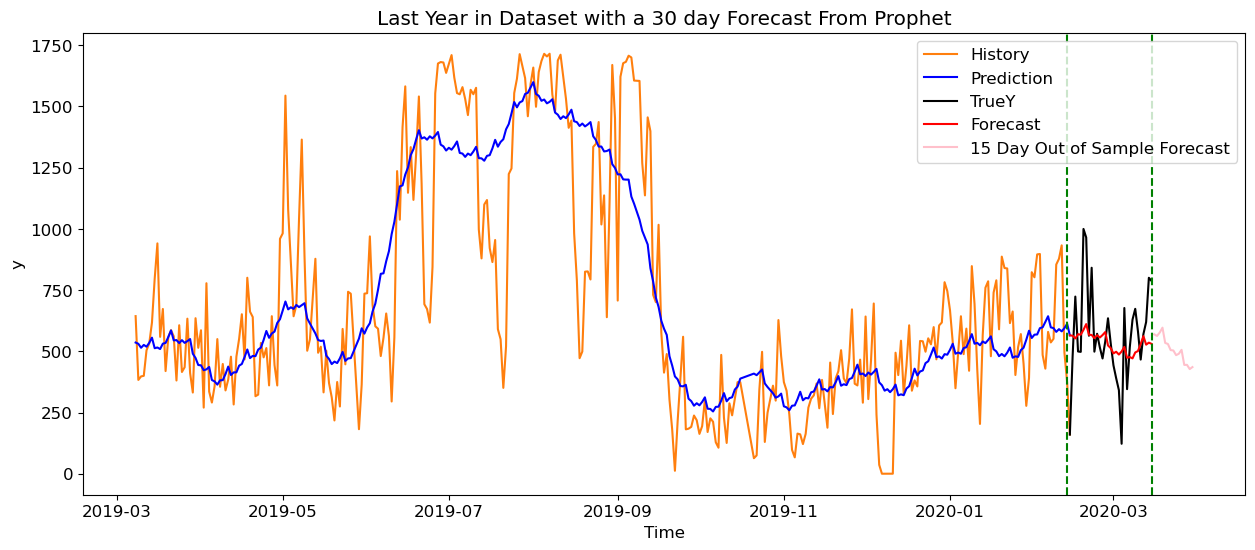

In [83]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast['yhat'][-k:], color='red', label='Forecast')
ax.plot(out['Date'], out['Forecasting'], color='pink', label='15 Day Out of Sample Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')
ax.axvline(x=df.index[-1], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Prophet')
plt.legend()